#### Imports & Downloads

In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgboost
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
import vectorize_functions

from sklearn.metrics import mean_squared_error
import time
import optuna

from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from typing import Tuple
from sklearn.metrics import log_loss
from optuna.samplers import TPESampler

### Einladen der vektorisierten Daten - FastText

In [3]:
X_train, X_test, y_train, y_test = vectorize_functions.vectorize_ft()

In [4]:
positive = np.count_nonzero(y_train == 1)
negative = np.count_nonzero(y_train == 0)
print("Train")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

positive = np.count_nonzero(y_test == 1)
negative = np.count_nonzero(y_test == 0)
print("Test")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

Train
- Positive: 1270
- Negative: 18084
- Verhältnis: 14.239370078740157
Test
- Positive: 541
- Negative: 7754
- Verhältnis: 14.33271719038817


In [5]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (19354, 300)
y_train shape (19354,)
X_test shape (8295, 300)
y_test shape (8295,)


### 2. Ensemble Models

In [47]:
evaluation = pd.DataFrame(
    columns=["model", "variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc", "test_prec",
             "test_rec", "test_f1"])

In [7]:
def add_to_eval_df(model, model_name, variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, variant, train_acc, train_precision, train_recall, train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [8]:
def evaluate_model(model, x_test, y_test, sampling_method):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'{sampling_method} model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### 2.1 Bagging

##### 2.1.1 RandomForest

###### RandomForest no tuning

In [9]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 94.43%
------------------------------------------------
Confusion Matrix:
      0    1
0  7727   27
1   435  106
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.80      0.20      0.31       541

    accuracy                           0.94      8295
   macro avg       0.87      0.60      0.64      8295
weighted avg       0.94      0.94      0.93      8295



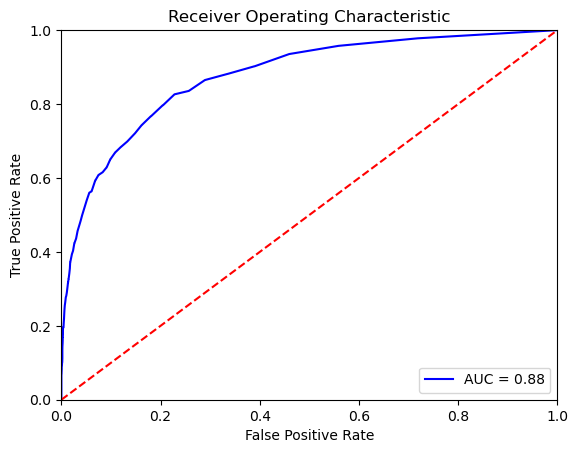

In [48]:
evaluate_model(rf, X_test, y_test, "none")
add_to_eval_df(rf, "RandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [11]:
cv = cross_val_score(rf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.329) total time=  14.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s


[CV] END ................................ score: (test=0.344) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.3s remaining:    0.0s


[CV] END ................................ score: (test=0.304) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.7s remaining:    0.0s


[CV] END ................................ score: (test=0.314) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.7s remaining:    0.0s


[CV] END ................................ score: (test=0.331) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.6s remaining:    0.0s


[CV] END ................................ score: (test=0.256) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   39.4s remaining:    0.0s


[CV] END ................................ score: (test=0.368) total time=   6.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   46.4s remaining:    0.0s


[CV] END ................................ score: (test=0.291) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   52.9s remaining:    0.0s


[CV] END ................................ score: (test=0.263) total time=  10.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] END ................................ score: (test=0.316) total time=   8.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished


In [12]:
np.mean(cv)

0.31177026207636793

###### RandomForest tuning (GridSearchCV)

In [13]:
# todo

###### RandomForest tuning (RandomizedSearchCV)

In [14]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [15]:
random_search = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=10)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=13, n_estimators=100
[CV 1/5; 1/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=13, n_estimators=100;, score=0.000 total time=   2.3s
[CV 2/5; 1/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=13, n_estimators=100
[CV 2/5; 1/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=13, n_estimators=100;, score=0.000 total time=   5.2s
[CV 3/5; 1/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=13, n_estimators=100
[CV 3/5; 1/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=13, n_estimators=100;, score=0.000 total time=   4.8s
[CV 4/5; 1/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=13, n_estimators=100
[CV 4/5; 1/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=13, n_estimators=100;, score=0.000 total time=   2.9s
[CV 5/5; 1/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=13, n_estimators=100
[CV 5/5; 1/10]

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=10)

In [16]:
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=13,
                       n_jobs=-1)


In [17]:
rf_tuned = RandomForestClassifier(**random_search.best_params_)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=13)

none model accuracy for classification is = 94.09%
------------------------------------------------
Confusion Matrix:
      0   1
0  7716  38
1   452  89
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.70      0.16      0.27       541

    accuracy                           0.94      8295
   macro avg       0.82      0.58      0.62      8295
weighted avg       0.93      0.94      0.92      8295



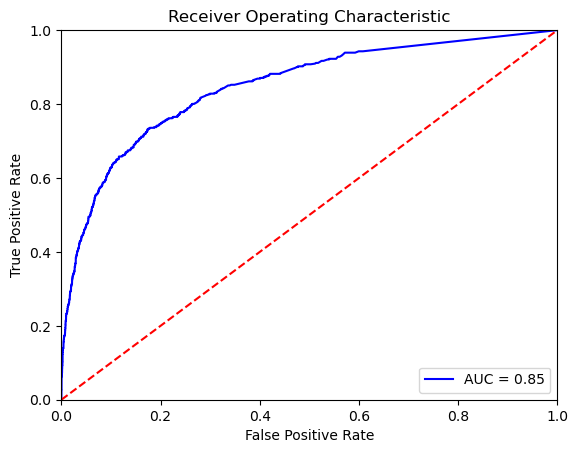

In [49]:
evaluate_model(rf_tuned, X_test, y_test, "none")
add_to_eval_df(rf_tuned, "RandomForestClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### RandomForest tuning (optuna)
https://gist.github.com/shamilnabiyev/c1b6e23444a949bc45243eab445a3806

In [70]:
def objective_rf(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=50)
    max_depth = trial.suggest_int(name="max_depth", low=10, high=150, step=5)
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1')
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

In [71]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study_rf = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
study_rf.optimize(objective_rf, n_trials=50)

[I 2024-11-24 21:22:58,128] A new study created in memory with name: no-name-5f138a9f-7cab-4469-9f2d-205229da02b4
[I 2024-11-24 21:24:33,590] Trial 0 finished with value: 0.30046149444714315 and parameters: {'n_estimators': 250, 'max_depth': 145, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.30046149444714315.
[I 2024-11-24 21:25:22,144] Trial 1 finished with value: 0.2874701049490754 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.30046149444714315.
[I 2024-11-24 21:27:10,232] Trial 2 finished with value: 0.2904352832888698 and parameters: {'n_estimators': 350, 'max_depth': 110, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.30046149444714315.
[I 2024-11-24 21:29:39,989] Trial 3 finished with value: 0.3167948665305661 and parameters: {'n_estimators': 450, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 3 with

Number of finished trials: 50
Best trial:
  Value: 0.32060501824678106
  Params: 
    n_estimators: 300
    max_depth: 95
    min_samples_split: 2
    min_samples_leaf: 1


C:\Users\admin\AppData\Local\Temp\ipykernel_15252\2334329262.py:12: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_rf)
C:\Users\admin\AppData\Local\Temp\ipykernel_15252\2334329262.py:13: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_rf)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

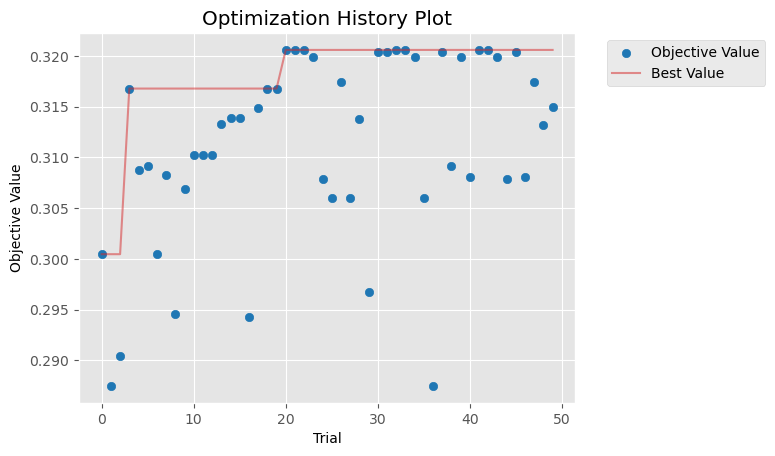

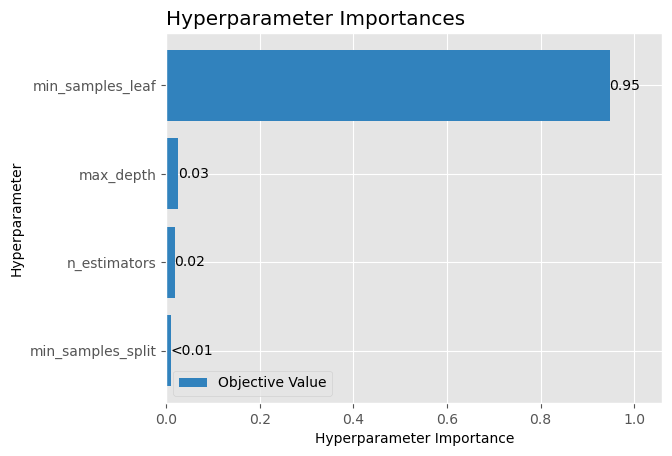

In [72]:
print("Number of finished trials: {}".format(len(study_rf.trials)))

print("Best trial:")
trial = study_rf.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

plot_optimization_history(study_rf)
plot_param_importances(study_rf)

none model accuracy for classification is = 94.33%
------------------------------------------------
Confusion Matrix:
      0   1
0  7726  28
1   442  99
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.78      0.18      0.30       541

    accuracy                           0.94      8295
   macro avg       0.86      0.59      0.63      8295
weighted avg       0.94      0.94      0.93      8295



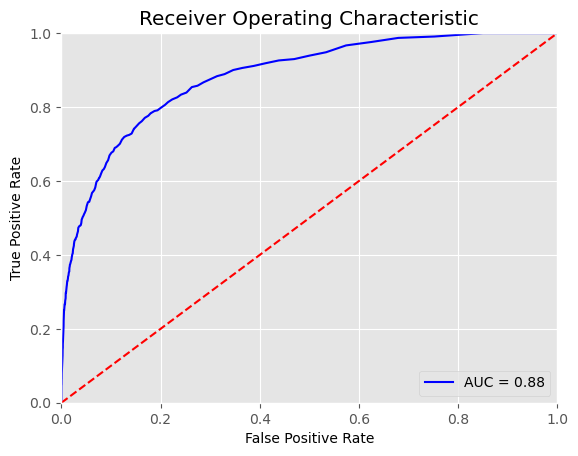

In [73]:
rf_tuned_optuna = RandomForestClassifier(**study_rf.best_trial.params)
rf_tuned_optuna.fit(X_train, y_train)
evaluate_model(rf_tuned_optuna, X_test, y_test, "none")
add_to_eval_df(rf_tuned_optuna, "RandomForest-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.1.2 BalancedRandomForest untuned

###### BalancedRandomForest no tuning

In [19]:
brf = BalancedRandomForestClassifier(n_jobs=-1)
brf.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

BalancedRandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 83.77%
------------------------------------------------
Confusion Matrix:
      0     1
0  6513  1241
1   105   436
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7754
           1       0.26      0.81      0.39       541

    accuracy                           0.84      8295
   macro avg       0.62      0.82      0.65      8295
weighted avg       0.94      0.84      0.87      8295



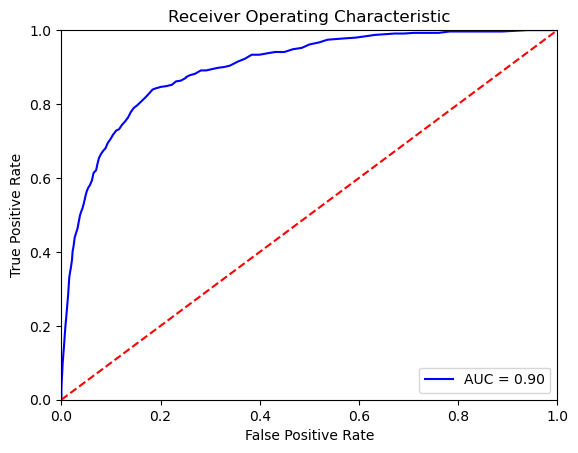

In [50]:
evaluate_model(brf, X_test, y_test, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [21]:
cv = cross_val_score(brf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] START .....................................................................
[CV] END ................................ score: (test=0.388) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.394) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.365) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.402) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.417) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.3s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.400) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.4s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.391) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.399) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.0s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.366) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.3s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.391) total time=   1.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.6s finished


In [22]:
np.mean(cv)

0.3913099996470318

###### BalancedRandomForest tuning (RandomizedSearchCV)

In [23]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [24]:
random_search = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=0)
random_search.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: 

RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1')

In [25]:
brf_tuned = BalancedRandomForestClassifier(**random_search.best_params_, verbose=0)
brf_tuned.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

BalancedRandomForestClassifier(max_depth=9, max_leaf_nodes=9, n_estimators=200)

none model accuracy for classification is = 81.70%
------------------------------------------------
Confusion Matrix:
      0     1
0  6354  1400
1   118   423
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      7754
           1       0.23      0.78      0.36       541

    accuracy                           0.82      8295
   macro avg       0.61      0.80      0.63      8295
weighted avg       0.93      0.82      0.86      8295



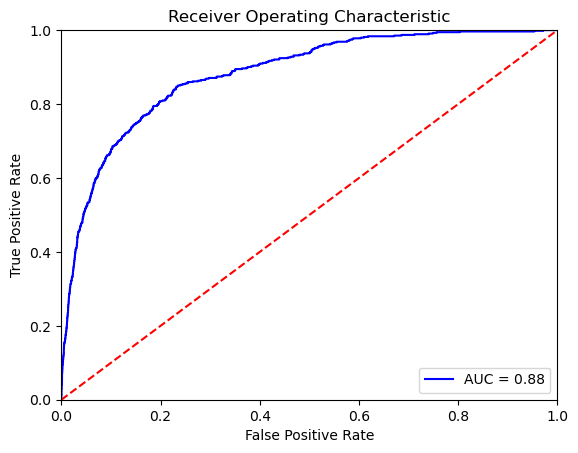

In [52]:
evaluate_model(brf_tuned, X_test, y_test, "none")
add_to_eval_df(brf_tuned, "BalancedRandomForestClassifier-tuned", "clean", X_train, y_train, X_test, y_test)

#### 2.2 Boosting

##### 2.2.1 XGBClassifier

In [27]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 94.68%
------------------------------------------------
Confusion Matrix:
      0    1
0  7676   78
1   363  178
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.70      0.33      0.45       541

    accuracy                           0.95      8295
   macro avg       0.83      0.66      0.71      8295
weighted avg       0.94      0.95      0.94      8295



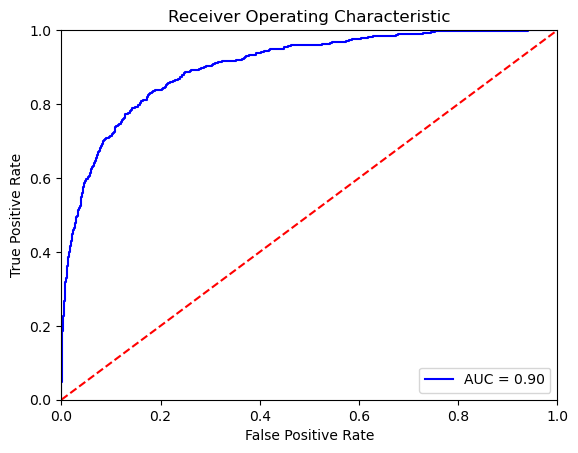

In [53]:
evaluate_model(xgb, X_test, y_test, "none")
add_to_eval_df(xgb, "XGBClassifier", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (GridSearchCV)
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Tuning mit GridSearchCV dauert bei großer param-Liste sehr lange, daher einzelne Schritte mit jeweils nur 1 bis max. 2 params

auskommentierte Werte stammen aus TF-IDF GridSearch


In [30]:
param_test = {
    'learning_rate': [0.1, 0.01, 0.001],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.32039688186494825, {'learning_rate': 0.1})

In [31]:
xgb_test = XGBClassifier(learning_rate=0.1)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")


KeyboardInterrupt



In [ ]:
param_test = {
    'n_estimators': range(100, 250, 50),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.37817637241282653, {'n_estimators': 200})

In [ ]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [ ]:
param_test = {
    'max_depth': range(5, 13, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4298347587940351, {'max_depth': 11})

In [ ]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [ ]:
param_test = {
    'subsample': [0.5, 0.7, 1]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'subsample': 0.7})

In [ ]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [ ]:
param_test = {
    'min_child_weight': range(1, 6, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'min_child_weight': 1}) <== kein Einfluss auf Modellperformance

In [ ]:
param_test = {
    'gamma': [i / 10.0 for i in range(0, 5)],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'gamma': 0.0}) <== kein Einfluss auf Modellperformance

In [ ]:
param_test = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# (0.44114103318625436, {'reg_alpha': 0.01})

In [ ]:
param_test = {
    'reg_alpha': [0.005, 0.01, 0.015, 0.02, 0.025]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# # (0.44114103318625436, {'reg_alpha': 0.01})

In [32]:
xgb_tuned_grid = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
xgb_tuned_grid.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 94.78%
------------------------------------------------
Confusion Matrix:
      0    1
0  7690   64
1   369  172
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.73      0.32      0.44       541

    accuracy                           0.95      8295
   macro avg       0.84      0.65      0.71      8295
weighted avg       0.94      0.95      0.94      8295



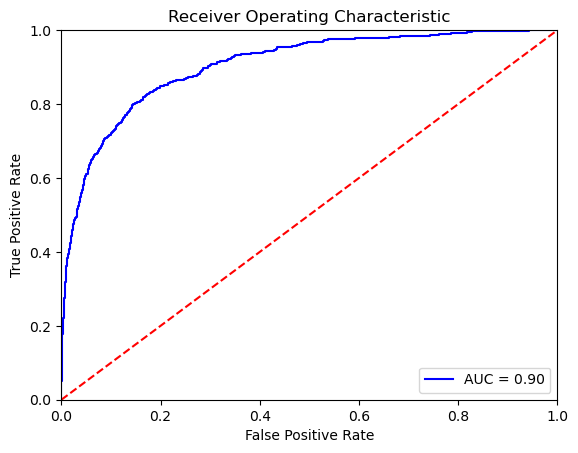

In [54]:
evaluate_model(xgb_tuned_grid, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_grid, "XGBClassifier-tuned-grid", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (RandomizedSearchCV)
Vergleich Modellperformance zwischen GridSearchCV <-> RandomizedSearchCV

In [34]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(100, 250, 50),
    'max_depth': range(5, 13, 2),
    'subsample': [0.5, 0.7, 1],
    'min_child_weight': range(1, 6, 2),
    'gamma': [i / 10.0 for i in range(0, 5)],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
}

In [35]:
rsearch = RandomizedSearchCV(XGBClassifier(n_jobs=-1),
                             param_grid,
                             scoring='f1',
                             verbose=1,
                             cv=5,
                             )

In [36]:
rsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': range(5, 13, 2),
                                        'min_child_weight': range(1, 6, 2),
                                        'n_estimators': range(100, 250, 50),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.5, 0.7, 1]},
                   scoring='f1', verbose=1)

In [37]:
rsearch.best_score_, rsearch.best_params_

(0.40697363371850204,
 {'subsample': 1,
  'reg_alpha': 1,
  'n_estimators': 100,
  'min_child_weight': 5,
  'max_depth': 9,
  'learning_rate': 0.1,
  'gamma': 0.4})

In [38]:
xgb_tuned_rand = XGBClassifier(**rsearch.best_params_, n_jobs=-1)
xgb_tuned_rand.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 94.90%
------------------------------------------------
Confusion Matrix:
      0    1
0  7695   59
1   364  177
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.75      0.33      0.46       541

    accuracy                           0.95      8295
   macro avg       0.85      0.66      0.71      8295
weighted avg       0.94      0.95      0.94      8295



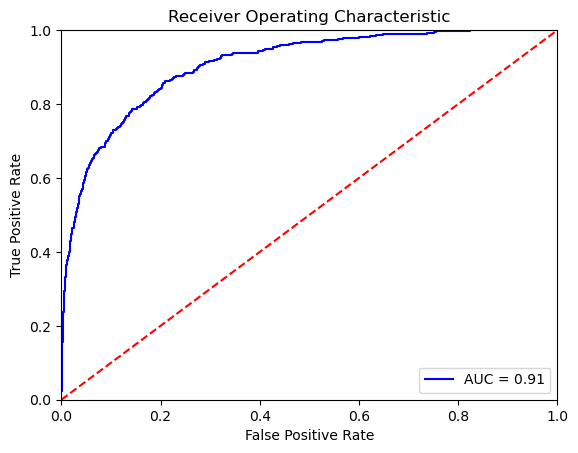

In [55]:
evaluate_model(xgb_tuned_rand, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_rand, "XGBClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (optuna)
https://randomrealizations.com/posts/xgboost-parameter-tuning-with-optuna/
https://www.kaggle.com/code/rzatemizel/optuna-xgboostcv-integration-with-pruning#Intro

In [45]:
def balancedlogloss(predt: np.ndarray, dtrain: xgboost.DMatrix) -> Tuple[str, float]:
    ''' balanced log loss metric.'''
    y = dtrain.get_label()
    target_mean = y.mean()
    w0 = 1 / (1 - target_mean)
    w1 = 1 / target_mean
    sample_weight = [w0 if y == 0 else w1 for y in y]
    loss = log_loss(y, predt, eps=1e-15, sample_weight=sample_weight)

    return 'balancedlogloss', loss

def objective(trial):
    dtrain = xgboost.DMatrix(X_train, label=y_train)

    param = {

        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.8),
        'scale_pos_weight': 509 / 108,
        'random_state': 42,
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 16)
        param["eta"] = trial.suggest_float("eta", 1e-3, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-balancedlogloss")
    history = xgboost.cv(param,
                     dtrain,
                     stratified=True,
                     nfold=5,
                     num_boost_round=10000,
                     early_stopping_rounds=50,
                     custom_metric=balancedlogloss,
                     seed=42,
                     callbacks=[pruning_callback])

    mean_balancedlogloss = history["test-balancedlogloss-mean"].values[-1]
    trial.set_user_attr("n_estimators", len(history))
    return mean_balancedlogloss


In [46]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study = optuna.create_study(sampler=sampler, pruner=pruner, direction="minimize")
study.optimize(objective, n_trials=5)

[I 2024-11-24 19:31:11,635] A new study created in memory with name: no-name-50622107-742c-434e-ac4c-816aa0551dfe
[I 2024-11-24 19:35:22,472] Trial 0 finished with value: 0.4744846 and parameters: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07, 'subsample': 0.2935967122017216, 'colsample_bytree': 0.23485016730091968}. Best is trial 0 with value: 0.4744846.
[I 2024-11-24 19:49:39,139] Trial 1 finished with value: 0.48108019999999996 and parameters: {'booster': 'gbtree', 'lambda': 1.4610865886287176e-08, 'alpha': 0.574485163632042, 'subsample': 0.6994655844802531, 'colsample_bytree': 0.3274034664069657, 'max_depth': 3, 'eta': 0.0035498788321965025, 'gamma': 2.716051144654844e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4744846.
[I 2024-11-24 19:50:02,634] Trial 2 finished with value: 0.476497 and parameters: {'booster': 'gblinear', 'lambda': 2.1734877073417355e-06, 'alpha': 8.528933855762793e-06, 'subsample': 0.4736419905302216, 

Number of finished trials: 5
Best trial:
  Value: 0.4744846
  Params: 
    booster: gblinear
    lambda: 0.0006155564318973012
    alpha: 1.77071686435378e-07
    subsample: 0.2935967122017216
    colsample_bytree: 0.23485016730091968


C:\Users\admin\AppData\Local\Temp\ipykernel_15252\993762437.py:13: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)
C:\Users\admin\AppData\Local\Temp\ipykernel_15252\993762437.py:14: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

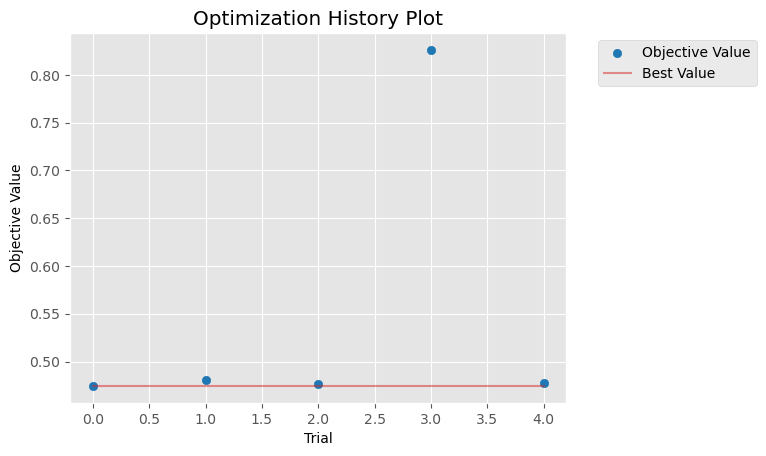

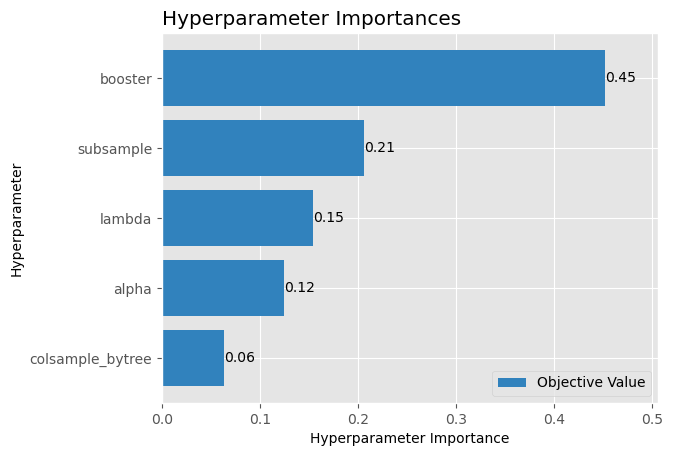

In [56]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

plot_optimization_history(study)
plot_param_importances(study)

none model accuracy for classification is = 93.91%
------------------------------------------------
Confusion Matrix:
      0   1
0  7693  61
1   444  97
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.61      0.18      0.28       541

    accuracy                           0.94      8295
   macro avg       0.78      0.59      0.62      8295
weighted avg       0.92      0.94      0.92      8295



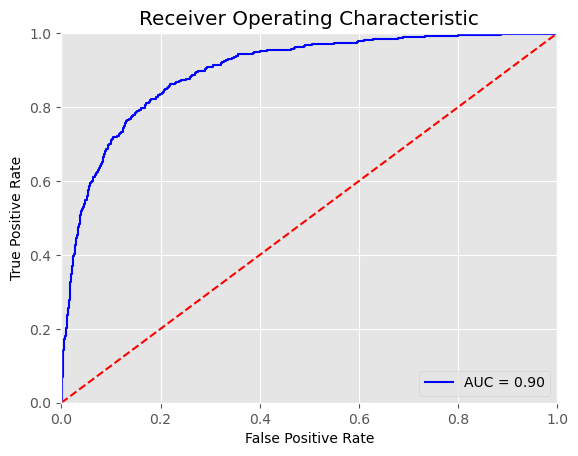

In [57]:
xgb_tuned_optuna = XGBClassifier(**study.best_trial.params)
xgb_tuned_optuna.fit(X_train, y_train)
evaluate_model(xgb_tuned_optuna, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_optuna, "XGBClassifier-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 CatBoostClassifier

In [58]:
cat = CatBoostClassifier(iterations=100,
                         depth=5,
                         learning_rate=0.1,
                         loss_function='Logloss',
                         verbose=True)
cat.fit(X_train, y_train)

0:	learn: 0.5564558	total: 178ms	remaining: 17.6s
1:	learn: 0.4592830	total: 202ms	remaining: 9.87s
2:	learn: 0.3861263	total: 226ms	remaining: 7.3s
3:	learn: 0.3332650	total: 251ms	remaining: 6.04s
4:	learn: 0.2969638	total: 277ms	remaining: 5.27s
5:	learn: 0.2684588	total: 301ms	remaining: 4.72s
6:	learn: 0.2456776	total: 328ms	remaining: 4.36s
7:	learn: 0.2295749	total: 353ms	remaining: 4.06s
8:	learn: 0.2155045	total: 378ms	remaining: 3.82s
9:	learn: 0.2074765	total: 404ms	remaining: 3.64s
10:	learn: 0.2001826	total: 430ms	remaining: 3.48s
11:	learn: 0.1933055	total: 455ms	remaining: 3.33s
12:	learn: 0.1876212	total: 481ms	remaining: 3.22s
13:	learn: 0.1838539	total: 505ms	remaining: 3.1s
14:	learn: 0.1802649	total: 530ms	remaining: 3s
15:	learn: 0.1773749	total: 554ms	remaining: 2.91s
16:	learn: 0.1751286	total: 579ms	remaining: 2.82s
17:	learn: 0.1726874	total: 603ms	remaining: 2.75s
18:	learn: 0.1705187	total: 627ms	remaining: 2.67s
19:	learn: 0.1687924	total: 652ms	remaining: 2

none model accuracy for classification is = 94.32%
------------------------------------------------
Confusion Matrix:
      0    1
0  7686   68
1   403  138
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.67      0.26      0.37       541

    accuracy                           0.94      8295
   macro avg       0.81      0.62      0.67      8295
weighted avg       0.93      0.94      0.93      8295



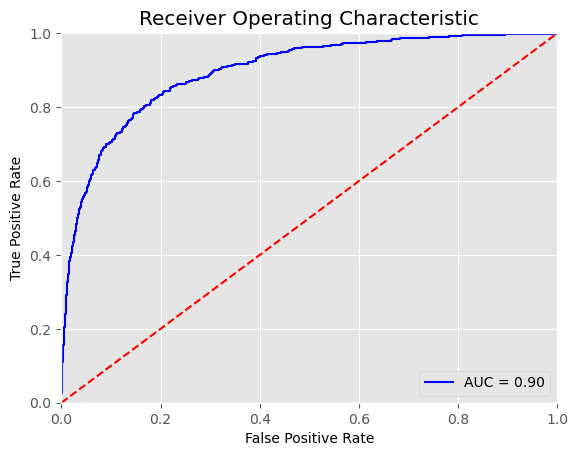

In [59]:
evaluate_model(cat, X_test, y_test, "none")
add_to_eval_df(cat, "CatBoostClassifier", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 LGBMClassifier

In [60]:
light = LGBMClassifier()
light.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1270, number of negative: 18084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 19354, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065620 -> initscore=-2.656011
[LightGBM] [Info] Start training from score -2.656011


LGBMClassifier()

none model accuracy for classification is = 94.61%
------------------------------------------------
Confusion Matrix:
      0    1
0  7677   77
1   370  171
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.69      0.32      0.43       541

    accuracy                           0.95      8295
   macro avg       0.82      0.65      0.70      8295
weighted avg       0.94      0.95      0.94      8295



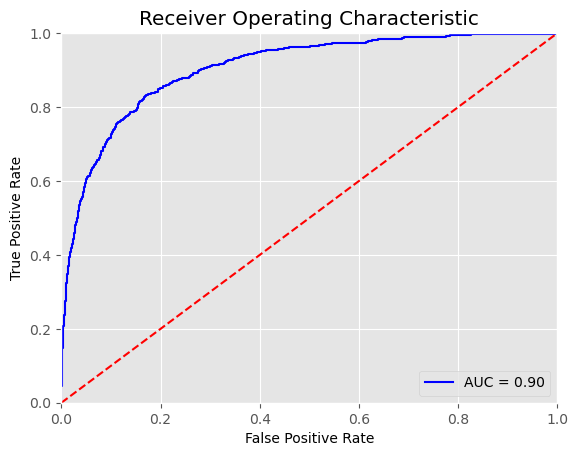

In [61]:
evaluate_model(light, X_test, y_test, "none")
add_to_eval_df(light, "LGBMClassifier", "clean", X_train, y_train, X_test, y_test)

#### 2.3 Stacking

##### 2.3.1 Stacking: RandomForest + LinearSVC

In [62]:
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]
stack = StackingClassifier(estimators=base_models, n_jobs=-1)

In [63]:
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', LinearSVC(random_state=42))],
                   n_jobs=-1)

none model accuracy for classification is = 94.60%
------------------------------------------------
Confusion Matrix:
      0    1
0  7688   66
1   382  159
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.71      0.29      0.42       541

    accuracy                           0.95      8295
   macro avg       0.83      0.64      0.69      8295
weighted avg       0.94      0.95      0.94      8295



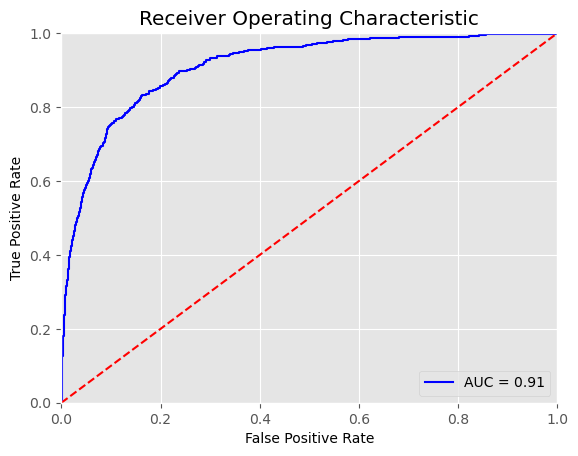

In [64]:
evaluate_model(stack, X_test, y_test, "none")
add_to_eval_df(stack, "StackingClassifier", "clean", X_train, y_train, X_test, y_test)

Vergleich: SVC

In [65]:
svc = LinearSVC()
svc.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [66]:
evaluate_model(svc, X_test, y_test, "none")
add_to_eval_df(svc, "LinearSVC", "clean", X_train, y_train, X_test, y_test)

none model accuracy for classification is = 94.32%
------------------------------------------------
Confusion Matrix:
      0    1
0  7720   34
1   437  104
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.75      0.19      0.31       541

    accuracy                           0.94      8295
   macro avg       0.85      0.59      0.64      8295
weighted avg       0.93      0.94      0.93      8295



AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

#### Model comparision

In [74]:
evaluation.sort_values(by=["test_prec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
0,RandomForestClassifier,clean,0.999948,0.999213,1.000000,0.999606,0.944304,0.796992,0.195933,0.314540
11,RandomForest-tuned-optuna,clean,0.999948,1.000000,0.999213,0.999606,0.943339,0.779528,0.182994,0.296407
6,XGBClassifier-tuned-rand,clean,0.998192,1.000000,0.972441,0.986028,0.949005,0.750000,0.327172,0.455598
5,XGBClassifier-tuned-grid,clean,0.999948,1.000000,0.999213,0.999606,0.947800,0.728814,0.317930,0.442728
10,StackingClassifier,clean,0.971065,0.914720,0.616535,0.736595,0.945992,0.706667,0.293900,0.415144
1,RandomForestClassifier-tuned-rand,clean,0.943526,0.784566,0.192126,0.308665,0.940928,0.700787,0.164510,0.266467
4,XGBClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.946835,0.695312,0.329020,0.446675
9,LGBMClassifier,clean,0.995298,0.993305,0.934646,0.963083,0.946112,0.689516,0.316081,0.433460
8,CatBoostClassifier,clean,0.952361,0.828302,0.345669,0.487778,0.943219,0.669903,0.255083,0.369478
7,XGBClassifier-tuned-optuna,clean,0.939651,0.618605,0.209449,0.312941,0.939120,0.613924,0.179298,0.277539


In [75]:
evaluation.sort_values(by=["test_rec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
2,BalancedRandomForestClassifier,clean,0.860184,0.319416,1.000000,0.484178,0.837734,0.259988,0.805915,0.393147
3,BalancedRandomForestClassifier-tuned,clean,0.817195,0.240741,0.829134,0.373140,0.816998,0.232035,0.781885,0.357868
4,XGBClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.946835,0.695312,0.329020,0.446675
6,XGBClassifier-tuned-rand,clean,0.998192,1.000000,0.972441,0.986028,0.949005,0.750000,0.327172,0.455598
5,XGBClassifier-tuned-grid,clean,0.999948,1.000000,0.999213,0.999606,0.947800,0.728814,0.317930,0.442728
9,LGBMClassifier,clean,0.995298,0.993305,0.934646,0.963083,0.946112,0.689516,0.316081,0.433460
10,StackingClassifier,clean,0.971065,0.914720,0.616535,0.736595,0.945992,0.706667,0.293900,0.415144
8,CatBoostClassifier,clean,0.952361,0.828302,0.345669,0.487778,0.943219,0.669903,0.255083,0.369478
0,RandomForestClassifier,clean,0.999948,0.999213,1.000000,0.999606,0.944304,0.796992,0.195933,0.314540
11,RandomForest-tuned-optuna,clean,0.999948,1.000000,0.999213,0.999606,0.943339,0.779528,0.182994,0.296407


In [76]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
6,XGBClassifier-tuned-rand,clean,0.998192,1.000000,0.972441,0.986028,0.949005,0.750000,0.327172,0.455598
4,XGBClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.946835,0.695312,0.329020,0.446675
5,XGBClassifier-tuned-grid,clean,0.999948,1.000000,0.999213,0.999606,0.947800,0.728814,0.317930,0.442728
9,LGBMClassifier,clean,0.995298,0.993305,0.934646,0.963083,0.946112,0.689516,0.316081,0.433460
10,StackingClassifier,clean,0.971065,0.914720,0.616535,0.736595,0.945992,0.706667,0.293900,0.415144
2,BalancedRandomForestClassifier,clean,0.860184,0.319416,1.000000,0.484178,0.837734,0.259988,0.805915,0.393147
8,CatBoostClassifier,clean,0.952361,0.828302,0.345669,0.487778,0.943219,0.669903,0.255083,0.369478
3,BalancedRandomForestClassifier-tuned,clean,0.817195,0.240741,0.829134,0.373140,0.816998,0.232035,0.781885,0.357868
0,RandomForestClassifier,clean,0.999948,0.999213,1.000000,0.999606,0.944304,0.796992,0.195933,0.314540
11,RandomForest-tuned-optuna,clean,0.999948,1.000000,0.999213,0.999606,0.943339,0.779528,0.182994,0.296407


In [77]:
evaluation['vectorize_variant'] = "ft"
evaluation = evaluation[['model',
 'variant',
 'vectorize_variant',
 'train_acc',
 'train_prec',
 'train_rec',
 'train_f1',
 'test_acc',
 'test_prec',
 'test_rec',
 'test_f1']]

outname = 'evaluation_ft.csv'

outdir = './eval_data'
if not os.path.exists(outdir):
    os.mkdir(outdir)

fullname = os.path.join(outdir, outname)

evaluation.to_csv(fullname)